# Model Results Visualization
This notebook is intended to pull model artifacts from the Neptune experiment logger and run it on a few samples from the dataset to see visualize how the different model's are segmenting the data. 

In [1]:
from neptune import Session
import pickle
from rasterio.plot import show
import pytorch_lightning as pl
import torch
import torchvision
import zipfile
from matplotlib import pyplot
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import segmentation_models_pytorch as smp

In [2]:
image_types = ['full_channel', 'rgb', 'ir', 'hsv', 'hsv_with_ir', 'veg_index']

In [3]:
f = open("image_samples.pkl", "rb")
image_samples = pickle.load(f)

In [4]:
# create session and import my project
sesh = Session.with_default_backend(api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5"
                                "lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOGE5NDI0YTktNmE2ZC00ZWZjLTlkMjAtNjNmMTIwM2Q2ZTQzIn0=")
project = sesh.get_project("maxzvyagin/GIS")

In [5]:
experiments = project.get_experiments()

In [ ]:
experiments

In [ ]:
e = experiments[0]
e.get_system_properties()
e.get_logs()['test_loss']['y']
e.state

precision


Text(0.5, 0.98, 'Experiment: precision, Test Loss: 0.3002199888938949')

array([[[ 6.1905247e-01,  1.7287609e-01, -1.1736951e-01, ...,
         -1.4503416e+00, -8.1215918e-01, -8.1049502e-01],
        [-1.8524872e-01, -7.2564058e-02, -6.5340716e-01, ...,
         -2.2250707e+00, -1.7331903e+00, -1.2704153e+00],
        [-8.9226741e-01, -3.4516716e-01, -4.5473689e-01, ...,
         -2.4634967e+00, -1.6852738e+00, -1.2539607e+00],
        ...,
        [-4.2866626e-01, -2.4395081e-01, -5.9602750e-03, ...,
          1.3958278e+00,  1.3653005e+00,  6.9859427e-01],
        [-9.3539089e-02,  1.8826924e-02,  1.9645345e-01, ...,
          9.4563538e-01,  1.1021788e+00,  3.4769014e-01],
        [-8.3044475e-01, -2.9455248e-01,  7.9980813e-02, ...,
          4.0667877e-01,  4.0003672e-01,  8.0712931e-04]]], dtype=float32)

(1, 1, 256, 256)


<AxesSubplot:title={'center':'Model Prediction'}>

<AxesSubplot:title={'center':'Ground Truth'}>

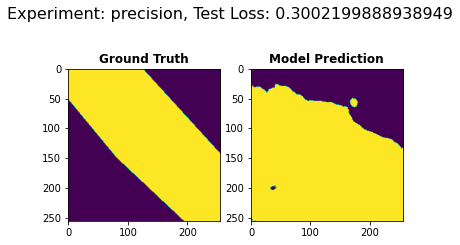

Text(0.5, 0.98, 'Experiment: precision, Test Loss: 0.3002199888938949')

array([[[-0.29924357, -0.8339882 , -1.1103743 , ..., -0.7860453 ,
         -0.33727056, -0.5635285 ],
        [-1.179449  , -1.8950716 , -2.4855897 , ..., -0.97253144,
         -0.69997257, -1.0778868 ],
        [-1.6517195 , -2.392777  , -2.7185967 , ..., -0.32723704,
         -0.4198234 , -0.71066177],
        ...,
        [-1.77948   , -2.3802226 , -2.3958793 , ...,  0.80377287,
          1.0406016 ,  0.5358974 ],
        [-0.96693504, -1.6313093 , -1.8304    , ...,  0.67986137,
          0.9588615 ,  0.17538014],
        [-1.304261  , -1.4463623 , -1.4250826 , ...,  0.36384997,
          0.36624688, -0.16616239]]], dtype=float32)

(1, 1, 256, 256)


<AxesSubplot:title={'center':'Model Prediction'}>

<AxesSubplot:title={'center':'Ground Truth'}>

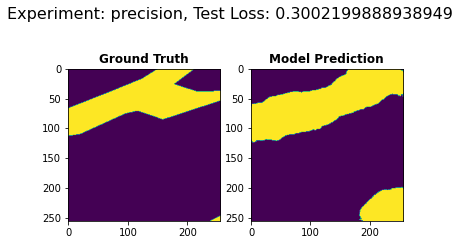

Text(0.5, 0.98, 'Experiment: precision, Test Loss: 0.3002199888938949')

array([[[-0.40652555, -0.89866304, -1.2365123 , ..., -1.0895311 ,
         -0.53544354, -0.6459659 ],
        [-1.3085873 , -1.8967845 , -2.4694512 , ..., -1.4211076 ,
         -1.2199197 , -1.224055  ],
        [-1.6626693 , -2.29389   , -2.6010225 , ..., -1.3511701 ,
         -1.1525673 , -0.99629927],
        ...,
        [-0.9295326 , -1.0750002 , -1.3427709 , ...,  0.833679  ,
          1.0623217 ,  0.49131683],
        [-0.31661835, -0.51223546, -0.6529732 , ...,  0.5583112 ,
          0.84958196,  0.16145614],
        [-1.0640613 , -0.706035  , -0.35171455, ...,  0.1821561 ,
          0.18475387, -0.05657838]]], dtype=float32)

(1, 1, 256, 256)


<AxesSubplot:title={'center':'Model Prediction'}>

<AxesSubplot:title={'center':'Ground Truth'}>

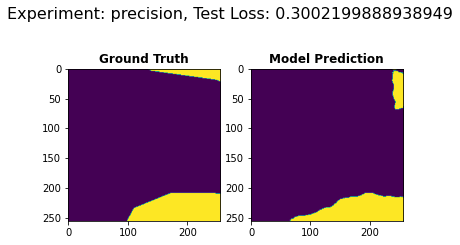

In [14]:
for e in experiments:
    id_num = int(e.get_system_properties()['id'].split('GIS-')[1])
    encoder = e.get_system_properties()['tags'][-1]
    if "encoder" in encoder:
        encoder = encoder.split("encoder")[1].lower()
    else:
        encoder = encoder.lower()
    if id_num == 449 and e.state == 'succeeded':
        # load in the model
        e.download_artifacts()
        with zipfile.ZipFile('output.zip') as zip_ref:
            zip_ref.extractall()
        f = open('output/latest_model.pkl', 'rb')
        device = torch.device('cpu')
        old_params = torch.load(f, map_location=device)
        params = dict()
        i_type = e.get_parameters()['image_type']
        if i_type == "full_channel":
            input_num = 4
        elif i_type == "rgb":
            input_num = 3
        elif i_type == "ir":
            input_num = 1
        elif i_type == "hsv":
            input_num = 3
        elif i_type == "hsv_with_ir":
            input_num = 4
        elif i_type == "veg_index":
            input_num = 1
        else:
            input_num = 4
        model = smp.Unet(classes=1, in_channels=4)
        # fix the weird state dict key error
        for k in old_params.keys():
            new_key = k.split("model.")[1]
            params[new_key] = old_params[k]
        # saving to variable to suppress huge printout
        print(encoder)
        y = model.load_state_dict(params)
        f.close()
        y = model.eval()
        # check the image type, and get image samples for corresponding image type
        # run the model on each of the samples and show results
        # print experiment id, name, image type, and training/test loss
        # print(e.get_properties(), e.get_numeric_channels_values())
        # show mask, and then show the results from each 
        for test in image_samples[i_type]:
            fig, (m_axis, i_axis) = pyplot.subplots(1, 2)
            fig.suptitle("Experiment: "+encoder+", Test Loss: "+e.get_logs()['test_loss']['y'], fontsize=16)
            if i_type == "veg_index":
                channel_input = test['image'].unsqueeze(0)
                channel_input = channel_input.unsqueeze(1)
                res = model(channel_input)
            else:
                res = model(test['image'].unsqueeze(0)).detach().numpy()
            #res = torch.max(output[:, 0, :, :], output[:, 1, :, :])
            res.squeeze(0)
            res[res >= 0] = 1
            res[res < 0] = 0
            #res = np.rint(res.detach().numpy())
#             res = torch.max(model(test['image'].unsqueeze(0)))
            #res = np.reshape(res, (2, 256, 256))
            print(res.shape) 
            #print(res[:10])
            show(res, ax=i_axis, title="Model Prediction")
            show(test['mask'], ax=m_axis, title="Ground Truth")
            pyplot.show()
    

In [ ]:
for e in experiments:
    # load in the model
    e.download_artifacts()
    with zipfile.ZipFile('output.zip') as zip_ref:
        zip_ref.extractall()
    f = open('output/latest_model.pkl', 'rb')
    device = torch.device('cpu')
    old_params = torch.load(f, map_location=device)
    params = dict()
    i_type = e.get_parameters()['image_type']
    if i_type == "full_channel":
        input_num = 4
    elif i_type == "rgb":
        input_num = 3
    elif i_type == "ir":
        input_num = 1
    elif i_type == "hsv":
        input_num = 3
    elif i_type == "hsv_with_ir":
        input_num = 4
    elif i_type == "veg_index":
        input_num = 1
    else:
        i_type = 4
    model =  torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=input_num,
                                    out_channels=1,
                                    init_features=32, pretrained=False)
    # fix the weird state dict key error
    for k in old_params.keys():
        new_key = k.split("model.")[1]
        params[new_key] = old_params[k]
    model.load_state_dict(params)
    f.close()
    # check the image type, and get image samples for corresponding image type
    # run the model on each of the samples and show results
    # print experiment id, name, image type, and training/test loss
    # print(e.get_properties(), e.get_numeric_channels_values())
    # show mask, and then show the results from each 
    for test in image_samples[i_type]:
        fig, (m_axis, i_axis) = pyplot.subplots(1, 2)
        fig.suptitle("Experiment: "+e.get_system_properties()['name']+", Test Loss: "+e.get_logs()['test_loss']['y'], fontsize=16)
        if i_type == "veg_index":
            channel_input = test['image'].unsqueeze(0)
            channel_input = channel_input.unsqueeze(1)
            res = model(channel_input)
        else:
            res = model(test['image'].unsqueeze(0))
        res = np.rint(res.detach().numpy())
        show(res, ax=i_axis, title="Model Prediction")
        show(test['mask'], ax=m_axis, title="Ground Truth")
        pyplot.show()
    